# #Exercise 1: Duplicate Detection and Removal
Objective: Identify and remove duplicate entries in the Titanic dataset.


In [88]:
# IMPORTS AT THE BEGINNING
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# sklearn imputer: SimpleImputer
from sklearn.impute import SimpleImputer

# sklearn preprocessing tools: StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.preprocessing import StandardScaler

# Display settings
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)


In [89]:
# MOUNT GOOGLE DRIVE
# Allows access to files stored in Google Drive
drive.mount('/content/drive')

# DEFINE PATH
# folder structure:
# MyDrive/
# └── BasesdeDatos/
#     └── titanic_train.csv

'''This version was downloaded from the competitor Titanic Kaggle. It has 12 columns, no duplicates, and includes the name field.
The Seaborn version doesn't include the name field and also has many duplicate records.'''


#Load the Titanic dataset.
my_titanic = pd.read_csv('/content/drive/My Drive/BasesdeDatos/titanic_train.csv')

my_titanic.info()
print (f'\nSize of the dataset: {my_titanic.shape[0]} rows x {my_titanic.shape[1]} columns')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Size of the dataset: 891 rows x 12 columns


In [90]:
# Identify if there are any duplicate rows based on all columns.

rows_before = my_titanic.shape[0]
print("Rows before removing duplicates:", rows_before)

# Create working copy
df = my_titanic.copy()

# Count duplicates:
duplicate_rows = df.duplicated()
print("Number of duplicate rows:", duplicate_rows.sum())

#View duplicates
duplicated_df = df[df.duplicated(keep=False)]
duplicated_df

print('\nWith no duplicate rows, there is no need to remove anything from the dataset')





Rows before removing duplicates: 891
Number of duplicate rows: 0

With no duplicate rows, there is no need to remove anything from the dataset


##Exercise 2: Handling Missing Values




Hint: Review methods like dropna(), fillna(), and SimpleImputer from scikit-learn.

In [91]:
#Identify columns in the Titanic dataset with missing values. Ussing isna().

print("Missing values:")
print(my_titanic.isna().sum())
print(f"\nTotal rows: {len(my_titanic)}")

missing_summary = (
    pd.DataFrame({
        'missing_count': my_titanic.isna().sum(),
        'missing_pct': my_titanic.isna().mean().mul(100).round(2)
    })
    .sort_values('missing_pct', ascending=False)
)


missing_summary = missing_summary.loc[missing_summary['missing_pct'] > 0] \
                                   .sort_values('missing_pct', ascending=False)

missing_summary



Missing values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Total rows: 891


,missing_count,missing_pct
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22


##Explore different strategies for handling missing data, such as removal, imputation, and filling with a constant value.

##Apply each strategy to different columns based on the nature of the data.

As a first step, a copy of the original dataset was made before.

df = my_titanic.copy()

In [92]:
#Cabin has 77% missing values, so the best practice is to drop/remove the column.

df = df.drop(columns=['Cabin'])

print(f"Dropped 'Cabin' column")
print(f"Columns: {len(my_titanic.columns)} -> {len(df.columns)}")

Dropped 'Cabin' column
Columns: 12 -> 11


In [93]:
#Age is a float and has 22% missing values; as a number, we can fill the missing values with SIMPLEIMPUTER, strategy='median'

print(f"Age missing before: {df['Age'].isnull().sum()}")

age_imputer = SimpleImputer(strategy='median')
df['Age'] = age_imputer.fit_transform(df[['Age']])

print(f"Median age used: {age_imputer.statistics_[0]}")

print(f"Age missing after: {df['Age'].isnull().sum()}")


Age missing before: 177
Median age used: 28.0
Age missing after: 0


In [94]:
# Embarked is categorical and has 0,22% missing values; we should fill them with the mode (most common)

print(f"Missing Embarked: {df['Embarked'].isna().sum()}")

most_common = df['Embarked'].mode()[0]

print(f"Most common port: {most_common}")

df['Embarked'] = df['Embarked'].fillna(most_common)
print(f"Missing Embarked now: {df['Embarked'].isna().sum()}")

Missing Embarked: 2
Most common port: S
Missing Embarked now: 0


#Exercise 3: Feature Engineering

Create new features:
* Family Size and is_alone from SibSp and Parch
* Title extracted from Name
* Age Groups from Age

In [95]:
# Inspect family columns: sibsp (siblings/spouses) and parch (parents/children)
df[['SibSp', 'Parch']].head(10)

,SibSp,Parch
0,1,0
1,1,0
2,0,0
3,1,0
4,0,0
5,0,0
6,0,0
7,3,1
8,0,2
9,1,0


In [96]:
# === CREATE FAMILY_SIZE ===
# family_size = sibsp + parch + 1 (the passenger itself)
df['family_size'] = df['SibSp'] + df['Parch'] + 1

# Check the distribution
df['family_size'].value_counts().sort_index()

,count
family_size,
1,537
2,161
3,102
4,29
5,15
6,22
7,12
8,6
11,7


In [97]:
# === Survival by Family Size ===
survival_by_family = ( df.groupby('family_size')['Survived'].mean().mul(100).round(2) )

survival_by_family

# Those who had the best chance of surviving were people with families of size 2, 3, or 4.

,Survived
family_size,
1,30.35
2,55.28
3,57.84
4,72.41
5,20.00
6,13.64
7,33.33
8,0.00
11,0.00


In [98]:
# === CREATE IS_ALONE ===
# Binary feature: 1 if family_size == 1, else 0
df['is_alone'] = (df['family_size'] == 1).astype(int)

# Check the distribution
df['is_alone'].value_counts().sort_index()


,count
is_alone,
0,354
1,537


In [99]:
# Compare survival rates: alone vs with family
survival_alone = ( df.groupby('is_alone')['Survived'].mean() . mul(100).round(2) )
survival_alone

# Those who had the best chance of surviving were the people accompanied by their families.

,Survived
is_alone,
0,50.56
1,30.35


In [100]:
# === EXTRACT TITLE WITH REGEX ===

df['title'] = df['Name'].str.extract(r',\s*([^.]+)\.')

# Check value_counts() of extracted titles
df['title'].value_counts()

,count
title,
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Col,2
Mlle,2
Major,2


In [101]:
# === SIMPLIFY TITLES ===
# Create mapping: common titles stay, rare ones become 'Rare'

title_mapping = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    # map rare/foreign titles
    'Dr': 'Rare',
    'Rev': 'Rare',
    'Col': 'Rare',
    'Mlle': 'Miss',
    'Major': 'Rare',
    'Ms': 'Mrs',
    'Mme': 'Mrs',
    'Don': 'Rare',
    'Lady': 'Rare',
    'Sir': 'Rare',
    'Capt': 'Rare',
    'the Countess': 'Rare',
    'Jonkheer': 'Rare'
}

df['title'] = df['title'].map(title_mapping)
df['title'].value_counts()

,count
title,
Mr,517
Miss,184
Mrs,127
Master,40
Rare,23


In [102]:
# === THE PAYOFF: Survival by Title ===
survival_by_title = (df.groupby('title')['Survived'].mean() .mul(100) . round (2))

survival_by_title

# Women (single or married) and children had a greater chance of survival compared to adult men.

,Survived
title,
Master,57.50
Miss,70.11
Mr,15.67
Mrs,79.53
Rare,34.78


##Exercise 4: Outlier Detection and Handling
Detect and cap or transform outliers in columns Fare and Age.

1. Visualize distributions using boxplots or histograms to identify potential outliers.
2. Use IQR or Z-score methods to detect them.
3. Handle outliers with:

Quantile capping (e.g. 0.98)
Log transformation
Row removal
4. Compare the dataset before and after treatment.

📌 Note: Small differences between 0.98 and 0.99 quantiles are normal when extreme values are rare or far apart. Use df.quantile() to explore and choose thresholds empirically, backed by visualization.

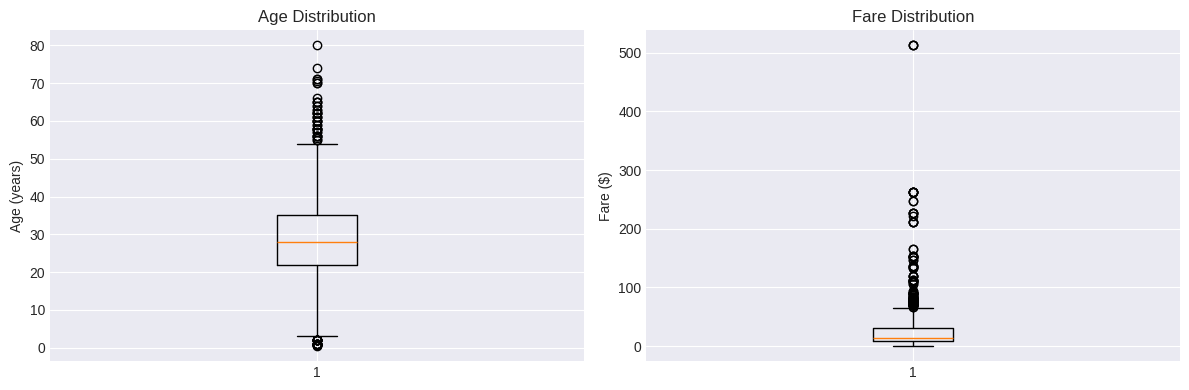

 
Box = middle 50% of data (Q1 to Q3)
  Line in box = median
  Whiskers = 1.5 × IQR from box
  Dots outside whiskers = OUTLIERS


In [103]:
# Outlier Inspection

# Visualize distributions with boxplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].boxplot(df['Age'].dropna())
axes[0].set_title('Age Distribution')
axes[0].set_ylabel('Age (years)')

axes[1].boxplot(df['Fare'].dropna())
axes[1].set_title('Fare Distribution')
axes[1].set_ylabel('Fare ($)')

plt.tight_layout()
plt.show()

print(" \nBox = middle 50% of data (Q1 to Q3)")
print("  Line in box = median")
print("  Whiskers = 1.5 × IQR from box")
print("  Dots outside whiskers = OUTLIERS")

In [104]:
# === EXAMINE AGE OUTLIERS ===

print(df['Age'].describe())
print(df.nlargest(20, 'Age')[['Name', 'Pclass', 'Age']])
print(df.nsmallest(10, 'Age')[['Name', 'Pclass', 'Age']])

count    891.000000
mean      29.361582
std       13.019697
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64
                                          Name  Pclass   Age
630       Barkworth, Mr. Algernon Henry Wilson       1  80.0
851                        Svensson, Mr. Johan       3  74.0
96                   Goldschmidt, Mr. George B       1  71.0
493                    Artagaveytia, Mr. Ramon       1  71.0
116                       Connors, Mr. Patrick       3  70.5
672                Mitchell, Mr. Henry Michael       2  70.0
745               Crosby, Capt. Edward Gifford       1  70.0
33                       Wheadon, Mr. Edward H       2  66.0
54              Ostby, Mr. Engelhart Cornelius       1  65.0
280                           Duane, Mr. Frank       3  65.0
456                  Millet, Mr. Francis Davis       1  65.0
438                          Fortune, Mr. Mark       1  64.0
545               Nic

In [105]:
# === CALCULATE IQR FOR AGE ===
Q1 = df['Age'].quantile(0.25)
Q3 = df['Age'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")
print(f"IQR: {IQR}")

print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

outliers = df[(df['Age'] < lower_bound) | (df['Age'] > upper_bound)]


print(f"Outliers detected: {len(outliers)/len(df) * 100:.1f}% of data - {len(outliers)} registers")

Q1 (25th percentile): 22.0
Q3 (75th percentile): 35.0
IQR: 13.0
Lower bound: 2.5
Upper bound: 54.5
Outliers detected: 7.4% of data - 66 registers


In [106]:
# === CAP OUTLIERS AT 1ST and 99TH PERCENTILE ===

# Calcular percentiles
lower_cap = df['Age'].quantile(0.01)
upper_cap = df['Age'].quantile(0.99)

# Contar valores fuera de rango
lower_outliers = (df['Age'] < lower_cap).sum()
upper_outliers = (df['Age'] > upper_cap).sum()

print(f"Capping fare at 1st percentile: {lower_cap:.2f}")
print(f"Capping fare at 99th percentile: {upper_cap:.2f}")
print(f"Values to be capped below: {lower_outliers}")
print(f"Values to be capped above: {upper_outliers}")
print(f"% Values to be capped in total: { (lower_outliers + upper_outliers) / len(df) * 100:.1f}% of data")


print("\nBefore capping")
print(f"Min Age: {df['Age'].min():.2f}")
print(f"Max Age: {df['Age'].max():.2f}")

# Aplicar capping en ambos lados
df['Age'] = df['Age'].clip(lower=lower_cap, upper=upper_cap)

print("\nAfter capping")
print(f"Min Age: {df['Age'].min():.2f}")
print(f"Max Age: {df['Age'].max():.2f}")

Capping fare at 1st percentile: 1.00
Capping fare at 99th percentile: 65.00
Values to be capped below: 7
Values to be capped above: 8
% Values to be capped in total: 1.7% of data

Before capping
Min Age: 0.42
Max Age: 80.00

After capping
Min Age: 1.00
Max Age: 65.00


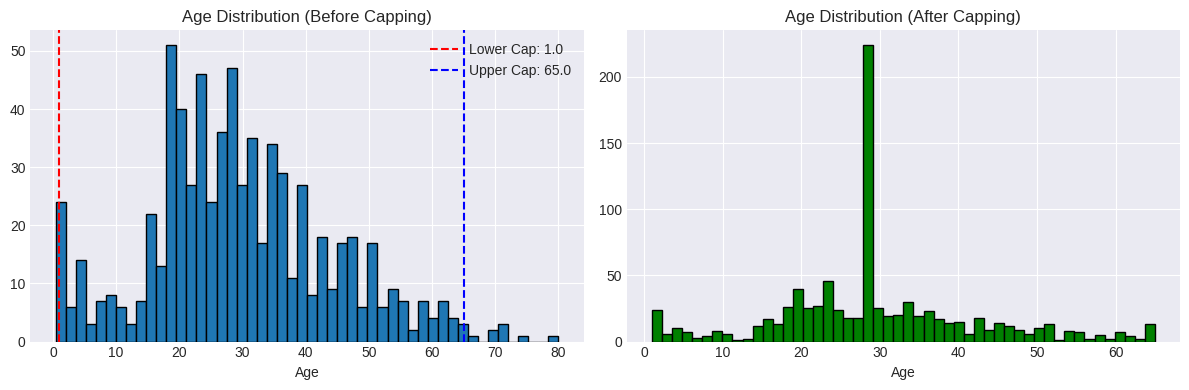

The extreme tails have been capped - very young and very old outliers no longer distort the distribution.


In [107]:
# Visualize the effect
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before (from original data)
axes[0].hist(my_titanic['Age'].dropna(), bins=50, edgecolor='black')
axes[0].set_title('Age Distribution (Before Capping)')
axes[0].set_xlabel('Age')

# líneas de corte inferior y superior
axes[0].axvline(x=lower_cap, color='red', linestyle='--', label=f'Lower Cap: {lower_cap:.1f}')
axes[0].axvline(x=upper_cap, color='blue', linestyle='--', label=f'Upper Cap: {upper_cap:.1f}')
axes[0].legend()

# After
axes[1].hist(df['Age'].dropna(), bins=50, edgecolor='black', color='green')
axes[1].set_title('Age Distribution (After Capping)')
axes[1].set_xlabel('Age')

plt.tight_layout()
plt.show()

print("The extreme tails have been capped - very young and very old outliers no longer distort the distribution.")


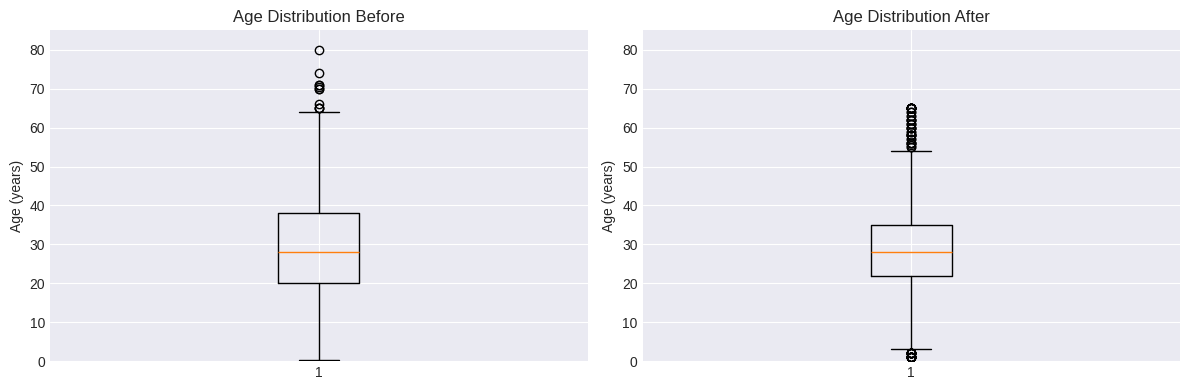

In [108]:
# Outlier inspection for Age - before vs after

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before
axes[0].boxplot(my_titanic['Age'].dropna())
axes[0].set_title('Age Distribution Before')
axes[0].set_ylabel('Age (years)')
axes[0].set_ylim(0, max(my_titanic['Age'].max(), df['Age'].max()) + 5)  # misma escala

# After
axes[1].boxplot(df['Age'].dropna())
axes[1].set_title('Age Distribution After')
axes[1].set_ylabel('Age (years)')
axes[1].set_ylim(0, max(my_titanic['Age'].max(), df['Age'].max()) + 5)  # misma escala

plt.tight_layout()
plt.show()


In [109]:
# === EXAMINE FARE OUTLIERS ===
print(df['Fare'].describe())
print(df.nlargest(20, 'Fare')[['Name', 'Pclass', 'Fare']])


count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64
                                                  Name  Pclass      Fare
258                                   Ward, Miss. Anna       1  512.3292
679                 Cardeza, Mr. Thomas Drake Martinez       1  512.3292
737                             Lesurer, Mr. Gustave J       1  512.3292
27                      Fortune, Mr. Charles Alexander       1  263.0000
88                          Fortune, Miss. Mabel Helen       1  263.0000
341                     Fortune, Miss. Alice Elizabeth       1  263.0000
438                                  Fortune, Mr. Mark       1  263.0000
311                         Ryerson, Miss. Emily Borie       1  262.3750
742              Ryerson, Miss. Susan Parker "Suzette"       1  262.3750
118                           Baxter, Mr. Quigg Edmond       1  247.5208
299    Bax

In [110]:
 #=== CALCULATE IQR FOR FARE ===
Q1 = df['Fare'].quantile(0.25)
Q3 = df['Fare'].quantile(0.75)
IQR = Q3 - Q1
# Calculate upper/lower bounds
# Count outliers

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1 (25th percentile): ${Q1}")
print(f"Q3 (75th percentile): ${Q3}")
print(f"IQR: ${IQR}")

print(f"Lower bound: ${lower_bound}")
print(f"Upper bound: ${upper_bound}")

outliers = df[(df['Fare'] < lower_bound) | (df['Fare'] > upper_bound)]

print(f"Outliers detected: {len(outliers)/len(df) * 100:.1f}% of data - {len(outliers)} registers")

Q1 (25th percentile): $7.9104
Q3 (75th percentile): $31.0
IQR: $23.0896
Lower bound: $-26.724
Upper bound: $65.6344
Outliers detected: 13.0% of data - 116 registers


In [111]:
# === CAP OUTLIERS AT 98TH PERCENTILE ===
fare_cap = df['Fare'].quantile(0.98)

outliers_count = (df['Fare'] > fare_cap).sum()

print(f"Capping fare at 98th percentile: ${fare_cap}")
print(f"Values to be capped: {outliers_count}")
print("Before capping")
print(f"Max fare: ${df['Fare'].max()}")


df['Fare'] = df['Fare'].clip(upper=fare_cap)
# Show before/after max values
print("After capping")
print(f"Max fare: ${df['Fare'].max()}")

Capping fare at 98th percentile: $211.3375
Values to be capped: 17
Before capping
Max fare: $512.3292
After capping
Max fare: $211.3375


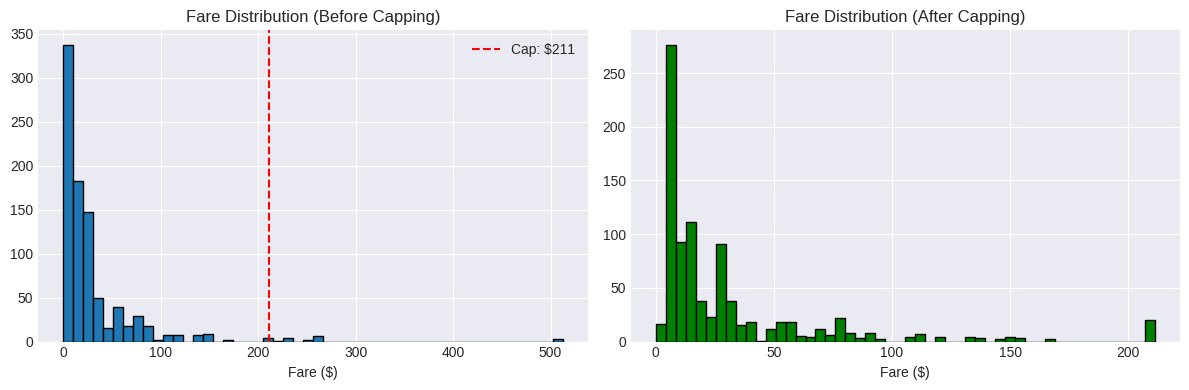

The extreme right tail has been capped - no more $500+ fares distorting our analysis.


In [112]:
# Visualize the effect
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before (from original data)
axes[0].hist(my_titanic['Fare'].dropna(), bins=50, edgecolor='black')
axes[0].set_title('Fare Distribution (Before Capping)')
axes[0].set_xlabel('Fare ($)')
axes[0].axvline(x=fare_cap, color='red', linestyle='--', label=f'Cap: ${fare_cap:.0f}')
axes[0].legend()

# After
axes[1].hist(df['Fare'].dropna(), bins=50, edgecolor='black', color='green')
axes[1].set_title('Fare Distribution (After Capping)')
axes[1].set_xlabel('Fare ($)')

plt.tight_layout()
plt.show()

print("The extreme right tail has been capped - no more $500+ fares distorting our analysis.")

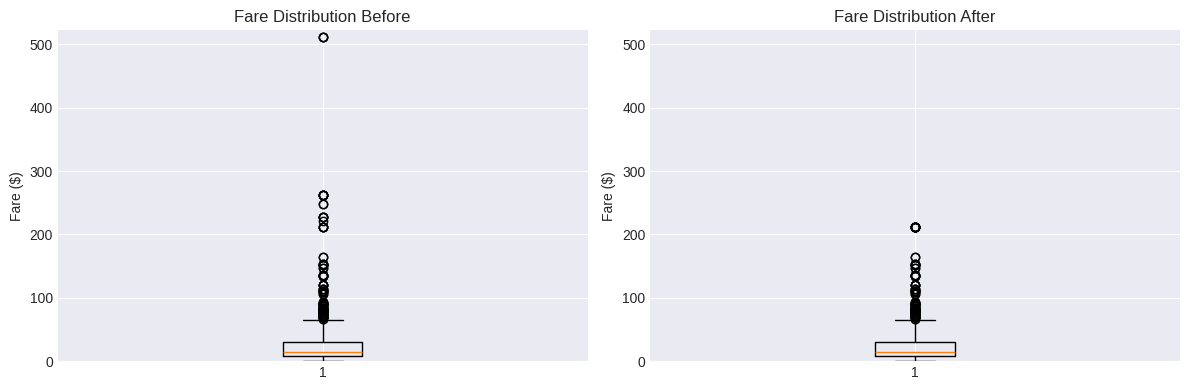

In [113]:
# Outlier inspection for Fare - before vs after

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before capping
axes[0].boxplot(my_titanic['Fare'].dropna())
axes[0].set_title('Fare Distribution Before')
axes[0].set_ylabel('Fare ($)')
axes[0].set_ylim(0, max(my_titanic['Fare'].max(), df['Fare'].max()) + 10)  # misma escala

# After capping
axes[1].boxplot(df['Fare'].dropna())
axes[1].set_title('Fare Distribution After')
axes[1].set_ylabel('Fare ($)')
axes[1].set_ylim(0, max(my_titanic['Fare'].max(), df['Fare'].max()) + 10)  # misma escala

plt.tight_layout()
plt.show()


#Exercise 5: Data Standardization and Normalization

Goal: Scale numerical features to prepare for modeling.

Use StandardScaler (mean = 0, std = 1) for normally distributed features.

In [114]:
# === CHECK CURRENT SCALES ===
# Age and fare are not in the same scale

print(f'Stats Age: min = {df['Age'].min()} ; max = {df['Age'].max()} ; mean = {df['Age'].mean()}')
print(f'Stats Fare: min = {df['Fare'].min()} ; max = {df['Fare'].max()} ; mean = {df['Fare'].mean()}')


Stats Age: min = 1.0 ; max = 65.0 ; mean = 29.304713804713806
Stats Fare: min = 0.0 ; max = 211.3375 ; mean = 30.678483052749723


In [115]:
# === APPLY STANDARDSCALER to Age and Fare toghether ===

scaler = StandardScaler()
df[['age_scaled', 'fare_scaled']] = scaler.fit_transform(df[['Age', 'Fare']])

In [116]:
# === VERIFY SCALING ===
# Check if mean ~ 0 and std ~ 1 for scaled columns

print("Age Scaled")
print(f"Mean: {df['age_scaled'].mean():.10f}")
print(f"Std:  {df['age_scaled'].std():.10f}")

print("\nFare Scaled")
print(f"Mean: {df['fare_scaled'].mean():.10f}")
print(f"Std:  {df['fare_scaled'].std():.10f}")

Age Scaled
Mean: -0.0000000000
Std:  1.0005616400

Fare Scaled
Mean: -0.0000000000
Std:  1.0005616400


In [117]:
# Compare original vs scaled values
df[['age_scaled', 'Age' , 'fare_scaled', 'Fare']].head()

,age_scaled,Age,fare_scaled,Fare
0,-0.569558,22.0,-0.587437,7.2500
1,0.677983,38.0,1.018110,71.2833
2,-0.257673,26.0,-0.570512,7.9250
3,0.444069,35.0,0.562189,53.1000
4,0.444069,35.0,-0.567378,8.0500


#Exercise 6: Feature Encoding
Goal: Finalize categorical variable encoding.

1. Identify remaining categorical columns.
2. Apply:

 + One-Hot Encoding for nominal variables.
 + Label Encoding if any ordinal variables remain.

3. Merge encoded columns back into the main dataset.

📌 Reminder: Encoding comes after handling missing values and outliers, but before scaling (if applicable).

In [118]:
# === IDENTIFY CATEGORICAL COLUMNS ===
# What categorical columns do we need to encode?
# one-hot encoding = embarked, title
# label encoding = sex

print(f"embarked: {df['Embarked'].unique()}")
print(f"title: {df['title'].unique()}")

print(f"sex: {df['Sex'].unique()}")




embarked: ['S' 'C' 'Q']
title: ['Mr' 'Mrs' 'Miss' 'Master' 'Rare']
sex: ['male' 'female']


In [119]:
# === ONE-HOT ENCODE EMBARKED ===
embarked_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked').astype(int)
embarked_dummies.head()


,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [120]:
# === ONE-HOT ENCODE TITLE ===
title_dummies = pd.get_dummies(df['title'], prefix='title').astype(int)
title_dummies.head()


,title_Master,title_Miss,title_Mr,title_Mrs,title_Rare
0,0,0,1,0,0
1,0,0,0,1,0
2,0,1,0,0,0
3,0,0,0,1,0
4,0,0,1,0,0


In [121]:
# Add one-hot columns to our dataframe
df = pd.concat([df, embarked_dummies], axis=1)
df = pd.concat([df, title_dummies], axis=1)


In [122]:
# # === LABEL ENCODE SEX ===
# # Binary - use map({'male': 0, 'female': 1})
sex_mapping = {'male': 0, 'female': 1}
df['sex_encoded'] = df['Sex'].map(sex_mapping)
print(df[['Sex', 'sex_encoded']].head())

      Sex  sex_encoded
0    male            0
1  female            1
2  female            1
3  female            1
4    male            0


##Exercise 7: Data Transformation for Age Feature
Goal: Create and encode age groups.

Use pd.cut() to create bins for life stages (e.g. child, teen, adult, senior).

Apply one-hot encoding using pd.get_dummies(). --> I prefer to use Label Encoding because it is Ordinal.

Define bins and label them accordingly.


In [123]:
# === CREATE AGE GROUPS ===
bins = [0, 12, 18, 35, 60, 100]
labels = ['Child', 'Teen', 'Young Adult', 'Middle Aged', 'Senior']
df['age_group'] = pd.cut(df['Age'], bins=bins, labels=labels)
df['age_group'].value_counts()


,count
age_group,
Young Adult,535
Middle Aged,195
Teen,70
Child,69
Senior,22


In [124]:
# === SURVIVAL BY AGE GROUP ===
survival_by_age_group = (df.groupby('age_group')['Survived'].mean() .mul(100) . round (2))

survival_by_age_group

# Children and adolescents had a greater chance of survival, while young adults and seniors were the most affected.

/tmp/ipython-input-2464401943.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_by_age_group = (df.groupby('age_group')['Survived'].mean() .mul(100) . round (2))


,Survived
age_group,
Child,57.97
Teen,42.86
Young Adult,35.33
Middle Aged,40.00
Senior,22.73


In [125]:
print(f"age_group: {df['age_group'].unique()}")

age_group: ['Young Adult', 'Middle Aged', 'Child', 'Teen', 'Senior']
Categories (5, object): ['Child' < 'Teen' < 'Young Adult' < 'Middle Aged' < 'Senior']


In [126]:
# # === LABEL ENCODE age_group ===
# label encoding de age_group (has ordered categories):
# # ['Young Adult', 'Middle Aged', 'Child', 'Teen', 'Senior']
# #Categories (5, object): ['Child' < 'Teen' < 'Young Adult' < 'Middle Aged' < 'Senior']

df['age_group'] = pd.Categorical(
      df['age_group'],
      categories=['Child', 'Teen', 'Young Adult', 'Middle Aged', 'Senior'],
       ordered=True
   )

# Label encoding
df['age_group_encoded'] = df['age_group'].cat.codes
print(df[['age_group', 'age_group_encoded']].head())

     age_group  age_group_encoded
0  Young Adult                  2
1  Middle Aged                  3
2  Young Adult                  2
3  Young Adult                  2
4  Young Adult                  2


In [127]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'family_size', 'is_alone',
       'title', 'age_scaled', 'fare_scaled', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs',
       'title_Rare', 'sex_encoded', 'age_group', 'age_group_encoded'],
      dtype='object')

In [128]:
# # === Removes any duplicate columns ===
df = df.loc[:, ~df.columns.duplicated()].copy()

In [129]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_Q,Embarked_S,title_Master,title_Miss,title_Mr,title_Mrs,title_Rare,sex_encoded,age_group,age_group_encoded
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,1,0,0,1,0,0,0,Young Adult,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,1,0,1,Middle Aged,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,1,0,1,0,0,0,1,Young Adult,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,1,0,1,Young Adult,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,1,0,0,1,0,0,0,Young Adult,2


## Final Selection

In [131]:
# === ALL THE FEATURES ===

df.columns
# ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
#        'Parch', 'Ticket', 'Fare', 'Embarked', 'family_size', 'is_alone',
#        'title', 'age_scaled', 'fare_scaled', 'Embarked_C', 'Embarked_Q',
#        'Embarked_S', 'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs',
#        'title_Rare', 'sex_encoded', 'age_group', 'age_group_encoded']


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'family_size', 'is_alone',
       'title', 'age_scaled', 'fare_scaled', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs',
       'title_Rare', 'sex_encoded', 'age_group', 'age_group_encoded'],
      dtype='object')

In [132]:
# === SELECT FINAL FEATURES ===

# Choose features for the model:

feature_columns = [
  'Survived',
  'Pclass',
  'sex_encoded',
  'age_group_encoded',
  'age_scaled',
  'fare_scaled',
  'family_size',
  'is_alone',
# #One - Hot Encoded
  'Embarked_C',
  'Embarked_Q',
  'Embarked_S',
  'title_Master',
  'title_Miss',
  'title_Mr',
  'title_Mrs',
  'title_Rare'
 ]

#df final for machine learning
df_final = df[feature_columns].copy()


In [133]:
# === FINAL VERIFICATION ===
# Rows, features, missing values
# All numeric? Ready for ML?

df_final.head()

,Survived,Pclass,sex_encoded,age_group_encoded,age_scaled,fare_scaled,family_size,is_alone,Embarked_C,Embarked_Q,Embarked_S,title_Master,title_Miss,title_Mr,title_Mrs,title_Rare
0,0,3,0,2,-0.569558,-0.587437,2,0,0,0,1,0,0,1,0,0
1,1,1,1,3,0.677983,1.018110,2,0,1,0,0,0,0,0,1,0
2,1,3,1,2,-0.257673,-0.570512,1,1,0,0,1,0,1,0,0,0
3,1,1,1,2,0.444069,0.562189,2,0,0,0,1,0,0,0,1,0
4,0,3,0,2,0.444069,-0.567378,1,1,0,0,1,0,0,1,0,0


In [134]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Survived           891 non-null    int64  
 1   Pclass             891 non-null    int64  
 2   sex_encoded        891 non-null    int64  
 3   age_group_encoded  891 non-null    int8   
 4   age_scaled         891 non-null    float64
 5   fare_scaled        891 non-null    float64
 6   family_size        891 non-null    int64  
 7   is_alone           891 non-null    int64  
 8   Embarked_C         891 non-null    int64  
 9   Embarked_Q         891 non-null    int64  
 10  Embarked_S         891 non-null    int64  
 11  title_Master       891 non-null    int64  
 12  title_Miss         891 non-null    int64  
 13  title_Mr           891 non-null    int64  
 14  title_Mrs          891 non-null    int64  
 15  title_Rare         891 non-null    int64  
dtypes: float64(2), int64(13), 